# Failure Stresses

In [120]:
import collections
import copy
import functools
import unittest

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import special
from scipy import stats
import tensorflow as tf
import tensorflow_probability as tfp

from stat570 import datasets

failure_stresses = datasets.failure_stresses.load_data()
failure_stresses

,0,1,2,3,4,5,6,7,8,9,10,11,12
Length (mm),,,,,,,,,,,,,
1,2.247,2.640,2.842,2.908,3.099,3.126,3.245,3.328,3.355,3.383,3.572,3.581,3.681
10,1.901,2.132,2.203,2.228,2.257,2.350,2.361,2.396,2.397,2.445,2.454,2.454,2.474
20,1.312,1.314,1.479,1.552,1.700,1.803,1.861,1.865,1.944,1.958,1.966,1.997,2.006
50,1.339,1.434,1.549,1.574,1.589,1.613,1.746,1.753,1.764,1.807,1.812,1.840,1.852


## Model Specification

We specify priors for the scale, $\alpha \sim \operatorname{LogNormal}\left(\mu_\alpha, \sigma_\alpha\right)$, and the concentration (or shape), $\eta \sim \operatorname{LogNormal}\left(\mu_\eta, \sigma_\eta\right)$ for Weibull distribution: $Y \sim \operatorname{Weibull}\left(\alpha,\eta\right)$.

In [97]:
class WeibullModel:
    def __init__(self,
                 prior_alpha_mean, prior_alpha_standard_deviation,
                 prior_eta_mean, prior_eta_standard_deviation) -> None:
        self._prior_alpha_mean = prior_alpha_mean
        self._prior_alpha_standard_deviation = prior_alpha_standard_deviation
        self._prior_eta_mean = prior_eta_mean
        self._prior_eta_standard_deviation = prior_eta_standard_deviation
    
    def __call__(self, shape=()):
        alpha = tfp.edward2.as_random_variable(tfp.distributions.LogNormal(
            loc=self._prior_alpha_mean,
            scale=self._prior_alpha_standard_deviation,
            name='alpha'))
        
        eta = tfp.edward2.as_random_variable(tfp.distributions.LogNormal(
            loc=self._prior_eta_mean,
            scale=self._prior_eta_standard_deviation,
            name='eta'))
        
        return tfp.edward2.as_random_variable(tfp.distributions.TransformedDistribution(
            distribution=tfp.distributions.Uniform(high=1. + 1e-7),
            bijector=tfp.bijectors.Invert(
                tfp.bijectors.Weibull(scale=alpha, concentration=eta)),
            name='response'), sample_shape=shape)
    
    def make_log_joint_fn(self, labels):
        return functools.partial(
            tfp.edward2.make_log_joint_fn(lambda: self(tf.shape(labels))),
            response=labels)

## Inference

We construct a posterior over the model parameters and sample with MCMC to do inference on the parameters.

In [110]:
def model_fn(features, labels, mode, params, config):
    del features, config
    
    prior_alpha_mean = tf.convert_to_tensor(params['prior']['alpha']['mean'], tf.float32)
    prior_eta_mean = tf.convert_to_tensor(params['prior']['eta']['mean'], tf.float32)
    model = WeibullModel(
        prior_alpha_mean, tf.convert_to_tensor(params['prior']['alpha']['standard_deviation'], tf.float32),
        prior_eta_mean, tf.convert_to_tensor(params['prior']['eta']['standard_deviation'], tf.float32))
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return model().value
    
    log_joint_fn = model.make_log_joint_fn(labels)
    if mode == tf.estimator.ModeKeys.EVAL:
        return log_joint_fn(alpha=prior_alpha_mean, eta=prior_eta_mean)
    
    assert mode == tf.estimator.ModeKeys.TRAIN
        
    kernel = tfp.mcmc.HamiltonianMonteCarlo(
        num_leapfrog_steps=params['mcmc']['num_leapfrog_steps'],
        step_size=tf.get_variable('hmc_step_size_{}'.format(params['replica']),
                                  initializer=params['mcmc']['step_size'],
                                  use_resource=True, trainable=False),
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
        target_log_prob_fn=lambda alpha, eta: log_joint_fn(alpha=alpha, eta=eta),
        seed=params['mcmc']['seed'])
    
    states, _ = tfp.mcmc.sample_chain(
        kernel=kernel,  
        current_state=(
            tf.convert_to_tensor(params['mcmc']['initial_state']['alpha'], tf.float32),
            tf.convert_to_tensor(params['mcmc']['initial_state']['eta'], tf.float32)),
        num_results=params['mcmc']['num_results'],
        num_burnin_steps=params['mcmc']['num_burnin_steps'],
        num_steps_between_results=params['mcmc']['num_steps_between_results'],
        parallel_iterations=1)
    return states

## Choosing Prior Hyperparameters

In [111]:
def compute_log_norm_prior(l, u, density):
    """Computes the hyperparameters for lognormal distribution.
    
    Let X = exp(mu + sigma*Z). Computes mu and sigma such that
    P(l <= X <= u) = density.
    """
    tail_density = (1 - density)/2
    a, b = stats.norm.ppf(tail_density), stats.norm.ppf(1 - tail_density)    
    sigma = np.log(u/l)/(b - a)
    mu = np.log(u) - b*sigma
    return mu, sigma

class ComputeLogNormPrior(unittest.TestCase):    
    def test_compute_log_norm_prior(self):
        l, u = stats.uniform.rvs(0, 10), stats.uniform.rvs(20, 30)
        mu, sigma = compute_log_norm_prior(l, u, 0.9)
        self.assertAlmostEqual(
            stats.lognorm.cdf(l, scale=np.exp(mu), s=sigma), 0.05)
        self.assertAlmostEqual(
            stats.lognorm.sf(u, scale=np.exp(mu), s=sigma), 0.05)

unittest.main(argv=['_'], exit=False);

.
----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


We choose parameters with the values in the homework.

In [118]:
PARAMS = {
    'prior': {
        'eta': {'mean': 0., 'standard_deviation': 1.},
        'alpha': {'mean': 0., 'standard_deviation': 1.},
    },
    'mcmc': {
        'num_burnin_steps': 512,
        'num_leapfrog_steps': 3,
        'num_results': 2048,
        'num_steps_between_results': 2,
        'step_size': 1e-2,
        'initial_state': {
            'alpha': 3.5,
            'eta': 9.,
        },
        'seed': 2018,
    },
    'replica': '0',
}

# Specify priors according to tail probabilities.
PARAMS['prior']['alpha']['mean'], PARAMS['prior']['alpha']['standard_deviation'] = (
    compute_log_norm_prior(1., 4., 0.9))
PARAMS['prior']['eta']['mean'], PARAMS['prior']['eta']['standard_deviation'] = (
    compute_log_norm_prior(1./2., 30., 0.9))
# Generate an initial state from the priors.
np.random.seed(PARAMS['mcmc']['seed'])
PARAMS['mcmc']['initial_state']['alpha'] = stats.lognorm.rvs(
    scale=np.exp(PARAMS['prior']['alpha']['mean']),
    s=PARAMS['prior']['alpha']['standard_deviation'])
PARAMS['mcmc']['initial_state']['eta'] = stats.lognorm.rvs(
    scale=np.exp(PARAMS['prior']['eta']['mean']),
    s=PARAMS['prior']['eta']['standard_deviation'])

PARAMS

{'mcmc': {'initial_state': {'alpha': 1.7798272858229207,
   'eta': 7.990013271262216},
  'num_burnin_steps': 512,
  'num_leapfrog_steps': 3,
  'num_results': 2048,
  'num_steps_between_results': 2,
  'seed': 2018,
  'step_size': 0.01},
 'prior': {'alpha': {'mean': 0.6931471805599454,
   'standard_deviation': 0.4214035639417993},
  'eta': {'mean': 1.3540251005511053,
   'standard_deviation': 1.2445923744018637}},
 'replica': '0'}

## Running the Chains

We create a chain for each row data and run the chains in parallel.

In [144]:
from tensorflow.python import debug as tf_debug

np.set_printoptions(suppress=True)

def get_params(replica):
    params = copy.deepcopy(PARAMS)
    params['replica'] = replica
    return params

graph = tf.Graph()
with graph.as_default():
    features = tf.placeholder(name='features', dtype=tf.float32, shape=(None))
    labels_dict = {
        idx: tf.constant(data.values.astype(np.float32))
        for idx, data in failure_stresses.iterrows()
    }
    chain_ops = {
        idx: model_fn(features, labels, tf.estimator.ModeKeys.TRAIN,
                      get_params('train_{}'.format(idx)), tf.estimator.RunConfig())
        for idx, labels in labels_dict.items()
    }
    init_op = tf.group(tf.global_variables_initializer())
graph.finalize()

with graph.as_default(), tf.Session() as sess:
    sess.run(init_op)
    states = sess.run(chain_ops)

In [145]:
states = pd.DataFrame(np.vstack(states.values()).T,
                      columns=pd.MultiIndex.from_product(
                          [states.keys(), ['$\\alpha$', '$\\eta$']],
                          names=['Length (mm)', 'Parameter']))

In [153]:
summaries = pd.DataFrame(collections.OrderedDict([
    ('Posterior mean', states.mean()),
    ('Posterior median', states.median()),
    ('5% quantile', states.quantile(0.05)),
    ('95% quantile', states.quantile(0.95))
]))
summaries

Posterior mean  Posterior median  5% quantile  \
Length (mm) Parameter                                                  
1           $\alpha$         3.311466          3.314193     3.121779   
            $\eta$           9.015710          8.916229     5.934068   
10          $\alpha$         2.370603          2.369013     2.292519   
            $\eta$          14.950272         14.593380     9.399714   
20          $\alpha$         1.854666          1.855238     1.738347   
            $\eta$           8.104780          8.063134     5.343274   
50          $\alpha$         1.735096          1.735402     1.660220   
            $\eta$          11.215545         11.451363     7.413225   

                       95% quantile  
Length (mm) Parameter                
1           $\alpha$       3.494822  
            $\eta$        12.694072  
10          $\alpha$       2.450548  
            $\eta$        21.214439  
20          $\alpha$       1.968997  
            $\eta$        11.050812  
50          $\alpha$       1.809047  
            $\eta$        14.654419

In [115]:
failure_stresses.loc[1]

0     2.247
1     2.640
2     2.842
3     2.908
4     3.099
5     3.126
6     3.245
7     3.328
8     3.355
9     3.383
10    3.572
11    3.581
12    3.681
Name: 1, dtype: float64

In [124]:
for i, samples in states.items():
    print(i, np.mean(samples[0]*special.gamma(1 + 1/samples[1])), np.mean(samples, axis=-1))

1 3.1305249 [3.3114686 9.015717 ]
10 2.285112 [ 2.370602 14.950271]
20 1.744827 [1.8546654 8.10478  ]
50 1.656504 [ 1.7350941 11.21555  ]


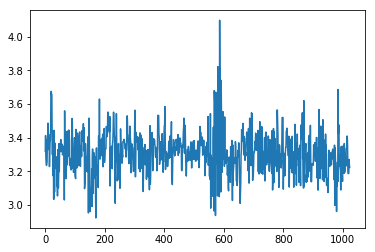

In [117]:
plt.plot(states[1][0])